<a href="https://colab.research.google.com/github/lidiasendinelwan/BelajarLLM2/blob/main/Belajar_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Install Depedencies
!python --version
!pip install transformers==4.18
!pip install bitsandbytes
!pip install datasets==1.16.1
!pip install accelerate

Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 50.2 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=7d750421798f3ae30b8fc6e63a1c7f072534b96d6dbebfa304686847c9cf4ca0
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
    

In [3]:
from sklearn.model_selection import train_test_split

import transformers

import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd

from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise

from tqdm.auto import tqdm

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
class FrozenBNBLinear(nn.Module):
    def __init__(self, weight, absmax, code, bias=None):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
        self.bias = bias

    def forward(self, input):
        output = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        output_clone = output.clone()
        if self.adapter:
            output_clone += self.adapter(input)
        return output_clone

    @classmethod
    def from_linear(cls, linear: nn.Linear) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias)

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"


class DequantizeAndLinear(torch.autograd.Function):
    @staticmethod
    @custom_fwd
    def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
                absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        ctx.save_for_backward(input, weights_quantized, absmax, code)
        ctx._has_bias = bias is not None
        return F.linear(input, weights_deq, bias)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output: torch.Tensor):
        assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
        input, weights_quantized, absmax, code = ctx.saved_tensors
        # grad_output: [*batch, out_features]
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        grad_input = grad_output @ weights_deq
        grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
        return grad_input, None, None, None, grad_bias


class FrozenBNBEmbedding(nn.Module):
    def __init__(self, weight, absmax, code):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None

    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            output = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            output += self.adapter(input)
        return output

    @classmethod
    def from_embedding(cls, embedding: nn.Embedding) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state)

    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"


def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.view(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)

    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)


def convert_to_int8(model):
    """Convert linear and embedding modules to 8-bit with optional adapters"""
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr(
                    module,
                    name,
                    FrozenBNBLinear(
                        weight=torch.zeros(child.out_features, child.in_features, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                        bias=child.bias,
                    ),
                )
            elif isinstance(child, nn.Embedding):
                setattr(
                    module,
                    name,
                    FrozenBNBEmbedding(
                        weight=torch.zeros(child.num_embeddings, child.embedding_dim, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                    )
                )

In [6]:
class GPTJBlock(transformers.models.gptj.modeling_gptj.GPTJBlock):
    def __init__(self, config):
        super().__init__(config)

        convert_to_int8(self.attn)
        convert_to_int8(self.mlp)


class GPTJModel(transformers.models.gptj.modeling_gptj.GPTJModel):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)


class GPTJForCausalLM(transformers.models.gptj.modeling_gptj.GPTJForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)


transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock

In [7]:
class T5ForConditionalGeneration(transformers.models.t5.modeling_t5.T5ForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        # convert_to_int8(self)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration = T5ForConditionalGeneration

In [8]:
config = transformers.GPTJConfig.from_pretrained("EleutherAI/gpt-j-6b")
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")

Downloading:   0%|          | 0.00/930 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [9]:
config.pad_token_id = config.eos_token_id
tokenizer.pad_token = config.pad_token_id

In [10]:
gpt = GPTJForCausalLM.from_pretrained("hivemind/gpt-j-6B-8bit", low_cpu_mem_usage=True)

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.75G [00:00<?, ?B/s]

k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, 

In [11]:
import json

f = open('train.json')

data = json.load(f)
array = {'Prompt':[]}
for i in data:
    if 'bot_reply' not in i:
        array['Prompt'].append('prompt:' + i['prompt'] + ',commands:' + i['completion'])
    else:
        array['Prompt'].append('commands:' + i['commands'] + ',bot_reply:' + i['bot_reply'])

dataset = pd.DataFrame.from_dict(array)
dataset.to_csv('/content/train_data.csv', index=False)

print(array['Prompt'])
# print(len(array['Prompt']))

['prompt:Berikan daftar interface yang ada di Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Saya membutuhkan informasi tentang semua interface di Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Tunjukkan daftar semua interface yang tersedia di Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Beri saya daftar semua antarmuka yang terhubung ke Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Saya ingin melihat daftar interface di Router B,commands:[Router B] show interfaces [eoc]', 'prompt:Tolong berikan informasi tentang semua interface yang tersedia di Router B,commands:[Router B] show interfaces [eoc]', 'prompt:Tunjukkan saya daftar semua antarmuka di Router B,commands:[Router B] show interfaces [eoc]', 'prompt:Berikan daftar semua antarmuka yang terhubung ke Router C,commands:[Router C] show interfaces [eoc]', 'prompt:Saya memerlukan informasi tentang semua interface di Router C,commands:[Router C] show interfaces [eoc]', 'prompt:Tu

In [12]:
print(array['Prompt'])

['prompt:Berikan daftar interface yang ada di Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Saya membutuhkan informasi tentang semua interface di Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Tunjukkan daftar semua interface yang tersedia di Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Beri saya daftar semua antarmuka yang terhubung ke Router A,commands:[Router A] show interfaces [eoc]', 'prompt:Saya ingin melihat daftar interface di Router B,commands:[Router B] show interfaces [eoc]', 'prompt:Tolong berikan informasi tentang semua interface yang tersedia di Router B,commands:[Router B] show interfaces [eoc]', 'prompt:Tunjukkan saya daftar semua antarmuka di Router B,commands:[Router B] show interfaces [eoc]', 'prompt:Berikan daftar semua antarmuka yang terhubung ke Router C,commands:[Router C] show interfaces [eoc]', 'prompt:Saya memerlukan informasi tentang semua interface di Router C,commands:[Router C] show interfaces [eoc]', 'prompt:Tu

In [13]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': '/content/train_data.csv'})

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ac9108a6de025a6c/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/packaged_modules/csv/csv.py:170: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
def tokenize_function(examples):
    return tokenizer(examples["Prompt"], padding=True, truncation=True, max_length= 1024)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["Prompt"])
tokenized_datasets.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
from torch.utils.data import DataLoader

full_train_dataset = tokenized_datasets["train"]
train_dataloader = DataLoader(full_train_dataset, shuffle=False, batch_size=8)

In [16]:
def add_adapters(model, adapter_dim=4, p = 0.1):
    assert adapter_dim > 0

    for name, module in model.named_modules():
      if isinstance(module, FrozenBNBLinear):
          if "attn" in name or "mlp" in name or "head" in name:
              print("Adding adapter to", name)
              module.adapter = nn.Sequential(
                nn.Linear(module.in_features, adapter_dim, bias=False),
                nn.Dropout(p=p),
                nn.Linear(adapter_dim, module.out_features, bias=False),
            )
              print("Initializing", name)
              nn.init.zeros_(module.adapter[2].weight)

          else:
              print("Not adding adapter to", name)
      elif isinstance(module, FrozenBNBEmbedding):
          print("Adding adapter to", name)
          module.adapter = nn.Sequential(
                nn.Embedding(module.num_embeddings, adapter_dim),
                nn.Dropout(p=p),
                nn.Linear(adapter_dim, module.embedding_dim, bias=False),
            )
          print("Initializing", name)
          nn.init.zeros_(module.adapter[2].weight)

add_adapters(gpt)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

Adding adapter to transformer.wte
Initializing transformer.wte
Adding adapter to transformer.h.0.attn.k_proj
Initializing transformer.h.0.attn.k_proj
Adding adapter to transformer.h.0.attn.v_proj
Initializing transformer.h.0.attn.v_proj
Adding adapter to transformer.h.0.attn.q_proj
Initializing transformer.h.0.attn.q_proj
Adding adapter to transformer.h.0.attn.out_proj
Initializing transformer.h.0.attn.out_proj
Adding adapter to transformer.h.0.mlp.fc_in
Initializing transformer.h.0.mlp.fc_in
Adding adapter to transformer.h.0.mlp.fc_out
Initializing transformer.h.0.mlp.fc_out
Adding adapter to transformer.h.1.attn.k_proj
Initializing transformer.h.1.attn.k_proj
Adding adapter to transformer.h.1.attn.v_proj
Initializing transformer.h.1.attn.v_proj
Adding adapter to transformer.h.1.attn.q_proj
Initializing transformer.h.1.attn.q_proj
Adding adapter to transformer.h.1.attn.out_proj
Initializing transformer.h.1.attn.out_proj
Adding adapter to transformer.h.1.mlp.fc_in
Initializing transfor

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): FrozenBNBLinear(4096, 50400)
)

In [17]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()
optimizer = Adam8bit(gpt.parameters(), lr=1e-5, weight_decay=0.01)

In [18]:
num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
print(num_training_steps)

680


In [19]:
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, int(num_training_steps*0.1), num_training_steps
)

In [20]:
from tqdm.auto import tqdm

train_loss_values = []
train_acc_values = []

scaler = torch.cuda.amp.GradScaler()
progress_bar = tqdm(range(num_training_steps))
gpt.train()
gpt.gradient_checkpointing_enable()
k = 0

metrics_path = '/content/metrics.json'
batch_size = 8

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    num_samples = 0

    for batch in train_dataloader:

        k = k + 1
        if k % 500 == 0:
          print(k)
          state = {'k' : k, 'epoch': num_epochs, 'lr_scheduler': lr_scheduler.state_dict(), 'state_dict': gpt.state_dict(), 'optimizer': optimizer.state_dict()}
          gpt.save_pretrained(f"/content/model-step-{k}/")

        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          out = gpt.forward(**batch,)

          loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                                reduction='mean', label_smoothing=0.1)

        print(loss)

        # calculate accuracy
        preds = torch.argmax(out.logits[:, :-1, :], axis=-1)
        acc = (preds == batch['input_ids'][:, 1:]).float().mean()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * batch_size
        running_acc += acc.item() * batch_size
        num_samples += batch_size

        lr_scheduler.step()
        progress_bar.update(1)

    epoch_loss = running_loss / num_samples
    epoch_acc = running_acc / num_samples

    # Append the loss and accuracy values to the respective lists
    train_loss_values.append(epoch_loss)
    train_acc_values.append(epoch_acc)

    # Print the metrics for this epoch
    print(f"Epoch {epoch+1}: train_loss = {epoch_loss:.3f}, train_acc = {epoch_acc:.3f}")

gpt.save_pretrained("/content/model/", state_dict=gpt.state_dict(), save_training_args=True)
# torch.save(gpt.state_dict(), "/content/weights.pth")
metrics = {'train_loss': train_loss_values, 'train_acc': train_acc_values}
torch.save(metrics, metrics_path)

  0%|          | 0/680 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.5087, device='cuda:0', grad_fn=<AddBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.6020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.1991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.8654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.4940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.4325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.0552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.0081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.4182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.2030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.9757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.9744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.7601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.5811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.7195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.7651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.5862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.7390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.7882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.5261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.5969, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6399, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6765, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.7124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.4191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.4452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.8910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.5270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.9640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 1: train_loss = 9.437, train_acc = 0.196
tensor(11.2360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.2993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.9105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.5571, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.1883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.0672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.7036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.6468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(11.0385, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.8106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.5692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.5625, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.3387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1990, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.3119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.3197, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.2941, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.2890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.0775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.0678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.0927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.1041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.0467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.0417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.2747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.2972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.6951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.3586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.8401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 2: train_loss = 9.039, train_acc = 0.197
tensor(10.3632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.3670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.0402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6719, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.3360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.0996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.7951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.6903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(10.0270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.8028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.5507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.5416, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.3267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1965, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1368, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9571, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.8909, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.8581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.9778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.9896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.3283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.0523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.6164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 3: train_loss = 8.146, train_acc = 0.201
tensor(8.9424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.9050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.6321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.6689, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.1050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8631, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.6517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.6549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.5670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.5473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.1211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.7017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.6927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.9712, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.7665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4556, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 4: train_loss = 6.940, train_acc = 0.200
tensor(7.2657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.6034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.7035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.5986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.3427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.5758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.5691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.3512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.3202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.4486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.1561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.3158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.2304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.3392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.9042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.8814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.8225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.7456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.6786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.5401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.4051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.5879, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.3051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 5: train_loss = 5.476, train_acc = 0.199
tensor(4.9643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.9904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.5843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.1010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.9847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.6581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.4137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.3203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.2096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.7476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.5869, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.5329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 6: train_loss = 3.339, train_acc = 0.555
tensor(2.6004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6265, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7023, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6584, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6178, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4551, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9153, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 7: train_loss = 2.592, train_acc = 0.842
tensor(2.4000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3969, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3998, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2764, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3302, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2969, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1995, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1584, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 8: train_loss = 2.398, train_acc = 0.885
tensor(2.2311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2345, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2689, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1177, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0739, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0571, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 9: train_loss = 2.270, train_acc = 0.898
tensor(2.0321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0393, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0771, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1014, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0644, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1258, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9296, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 10: train_loss = 2.144, train_acc = 0.905
tensor(1.8958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9399, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6298, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 11: train_loss = 2.032, train_acc = 0.918
tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8465, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7673, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8603, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8327, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 12: train_loss = 1.949, train_acc = 0.927
tensor(1.7228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7865, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8999, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4599, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 13: train_loss = 1.890, train_acc = 0.935
tensor(1.6894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 14: train_loss = 1.849, train_acc = 0.939
tensor(1.6637, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6783, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6969, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6239, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8092, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7432, device='cuda:0', grad_fn=<AddBackward0>)
500


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3438, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 15: train_loss = 1.819, train_acc = 0.942
tensor(1.6469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7822, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6812, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7925, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7840, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7817, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6995, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 16: train_loss = 1.797, train_acc = 0.945
tensor(1.6304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7720, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6183, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7083, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7849, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6239, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2774, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 17: train_loss = 1.780, train_acc = 0.947
tensor(1.6184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6912, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7399, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6965, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6554, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6662, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7712, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6982, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2579, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2576, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 18: train_loss = 1.768, train_acc = 0.948
tensor(1.6097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6777, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7628, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5973, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 19: train_loss = 1.761, train_acc = 0.949
tensor(1.6057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6861, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7292, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6826, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5774, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5973, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2380, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2379, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 20: train_loss = 1.756, train_acc = 0.949


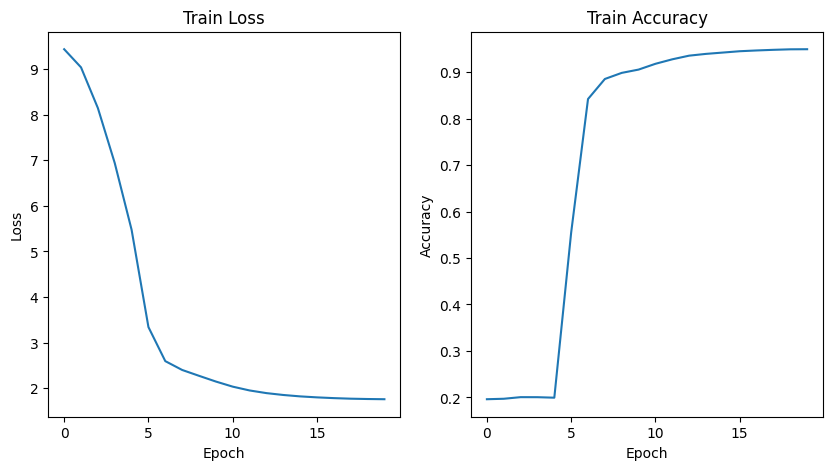

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))

# Create an index array for the epochs
epochs = np.arange(len(train_loss_values))

# Create two subplots, one for train loss and one for train accuracy
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot the train loss values on the first subplot
ax1.plot(epochs, metrics['train_loss'])
ax1.set_title('Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the train accuracy values on the second subplot
ax2.plot(epochs, metrics['train_acc'])
ax2.set_title('Train Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [22]:
!cp /content/model/* /content/drive/MyDrive/Tugas_Akhir/model/

In [24]:
#@title Load the finetuned model State_Dict to the Pretrained GPT-J Model

import random
from prettytable import PrettyTable
from difflib import SequenceMatcher

table = PrettyTable()
table.field_names = ["Prompt", "Generated Commands", "Correct Command", "Similarity (%)"]

network1 = ["192.168.7.0", "192.168.50.0", "192.168.32.0", "192.168.40.0"]

network2 = ["192.168.100.0", "192.168.10.0", "192.168.2.0", "192.168.5.0"]

router = ["Router A", "Router G", "Router X"]

interface = ["G0/2","G1","F0/0/1","F0/3"]

for i in range(1):
  current = [random.choice(network1), random.choice(network2), random.choice(router)]
  prompt = f"Buat route static menuju network 192.168.100.10 dengan subnet mask 255.255.255.0 melalui interface g/0/0/0 di Router A" #@param {type:"string"}
  correct_command = f"[{current[2]}] configure terminal, router rip, version 2, network {current[0]}, network {current[1]},  end [eoc]<|endoftext|>" #@param {type:"string"}
  with torch.no_grad():
    tokenized_prompt = tokenizer(f"prompt:{prompt},commands:[", truncation=True, padding=True, max_length=128, return_tensors='pt')
    for i in range(2):
      tokenized_prompt = {key: value.to(device) for key, value in tokenized_prompt.items()}
      out = gpt.generate(**tokenized_prompt, max_length=128, top_k=50, top_p=0.9, temperature=1.0, do_sample=True, repetition_penalty = 1.2, num_beams=1)
      outputs = tokenizer.decode(out[0]).split(",")
      outputs[1] = outputs[1].replace('\n',', ')
      similarity = SequenceMatcher(None, outputs[1].replace('commands:',''), correct_command).ratio() * 100
      row = [prompt, outputs[1].replace('commands:',''), correct_command, f"{similarity:.2f}%"]
      table.add_row(row)

print(table)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+----------------+
|                                                         Prompt                                                         |                                     Generated Commands                                    |                                                      Correct Command                                                       | Similarity (%) |
+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+------------------------------------------------------------------------

In [23]:
import re

input = f"Buat route static menuju network 192.168.100.10 dengan subnet mask 255.255.255.0 melalui interface g/0/0/0 di Router A" #@param {type:"string"}
gpt.eval()
prompt = f"prompt:{input},commands:["
with torch.no_grad():
  preprocessed_prompt = tokenizer(prompt, truncation=True, padding=True, max_length=256, return_tensors='pt')
  preprocessed_prompt = {key: value.to(device) for key, value in preprocessed_prompt.items()}
  out = gpt.generate(**preprocessed_prompt, max_length=128, top_k=50, top_p=0.9, temperature=1.0, do_sample=True, repetition_penalty = 1.2, num_beams=1)
  outputs = tokenizer.decode(out[0]).split(",")
  full_commands = outputs[1].replace('\n',',')

  print(full_commands)

  prompt = f"{outputs[1].replace('<|endoftext|>','')},bot_reply:"
  preprocessed_prompt = tokenizer(prompt, truncation=True, padding=True, max_length=256, return_tensors='pt')
  preprocessed_prompt = {key: value.to(device) for key, value in preprocessed_prompt.items()}
  out = gpt.generate(**preprocessed_prompt, max_length=512, top_k=50, top_p=0.9, temperature=1.0, do_sample=True, repetition_penalty = 1.2, num_beams=1)
  outputs = tokenizer.decode(out[0])

  pattern = r"bot_reply:(.*)"
  matches = re.findall(pattern, outputs, re.DOTALL)
  bot_reply_text = matches[0].strip()
  bot_reply = bot_reply_text.replace("\n",",")

  print(f'bot_reply:{bot_reply}')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


commands:[Router B] configure terminal,iproute[–Cocurrentaan adalah IPv4 address 192.168.1.2<|endoftext|>
bot_reply:Ada jalanan ini mengaktifkan semua layer sekuriti NAT untuk menyimpan<|endoftext|>


In [25]:
print(outputs)

['prompt:Buat route static menuju network 192.168.100.10 dengan subnet mask 255.255.255.0 melalui interface g/0/0/0 di Router A', 'commands:[RouterA] configure terminal, interface Gi/0/0/0 enable, encapsulation dot1q<|endoftext|>']


In [27]:
import csv
data = [table.field_names] + [[str(cell).strip() for cell in row] for row in table._rows]

# Write the data to a CSV file
filename = "table.csv"
with open(filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print(f"Table successfully converted to {filename}")

Table successfully converted to table.csv
